In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import os
from PIL import Image
import matplotlib.pyplot as plt
import shutil
from sklearn.model_selection import train_test_split

In [16]:
# Paths
original_dir = 'MyOutput_folder'
output_base = 'data'  # this will be created: data/train/... and data/val/...

# Get all image filenames
all_images = [f for f in os.listdir(original_dir) if f.endswith(('.jpg', '.png'))]

# Group by class based on filename prefix
class_files = {}
for img in all_images:
    label = img.split('_')[0].lower()
    class_files.setdefault(label, []).append(img)

# Split and move
for label, files in class_files.items():
    train_files, val_files = train_test_split(files, test_size=0.2, random_state=42)

    for split, split_files in zip(['train', 'val'], [train_files, val_files]):
        output_dir = os.path.join(output_base, split, label)
        os.makedirs(output_dir, exist_ok=True)

        for file in split_files:
            src = os.path.join(original_dir, file)
            dst = os.path.join(output_dir, file)
            shutil.copy(src, dst)  # or shutil.move() if you want to move instead of copy

print("Images have been split into train/val folders.")

Images have been split into train/val folders.


In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_dir = 'data/train'
val_dir = 'data/val'
img_size = 224
batch_size = 16
num_classes = 7

In [20]:
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],  # ImageNet mean
                         [0.229, 0.224, 0.225])  # ImageNet std
])

In [22]:
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
val_dataset = datasets.ImageFolder(val_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

class_names = train_dataset.classes
print("Class names:", class_names)

Class names: ['brain', 'hearth', 'kidney', 'liver', 'lung', 'ovary', 'uterus']


In [24]:
model = models.resnet18(pretrained=True)

# Freeze the base layers
for param in model.parameters():
    param.requires_grad = False

# Replace the final layer
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

C:\Users\bioha\anaconda3_1\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\bioha\anaconda3_1\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [26]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

In [28]:
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")

Epoch 1/5, Loss: 1.8494
Epoch 2/5, Loss: 1.3249
Epoch 3/5, Loss: 0.9544
Epoch 4/5, Loss: 0.8020
Epoch 5/5, Loss: 0.6221


In [30]:
train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []

# Training Loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_accuracies.append(correct_train / total_train * 100)
    train_losses.append(running_loss / len(train_loader))

    # Validation Loop
    model.eval()
    correct_val = 0
    total_val = 0
    val_loss = 0.0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_accuracies.append(correct_val / total_val * 100)
    val_losses.append(val_loss / len(val_loader))

    print(f"Epoch {epoch+1}/{num_epochs} | Train Accuracy: {train_accuracies[-1]:.2f}% | Val Accuracy: {val_accuracies[-1]:.2f}%")


Epoch 1/5 | Train Accuracy: 86.97% | Val Accuracy: 89.33%
Epoch 2/5 | Train Accuracy: 87.32% | Val Accuracy: 84.00%
Epoch 3/5 | Train Accuracy: 89.44% | Val Accuracy: 85.33%
Epoch 4/5 | Train Accuracy: 89.79% | Val Accuracy: 92.00%
Epoch 5/5 | Train Accuracy: 91.90% | Val Accuracy: 86.67%


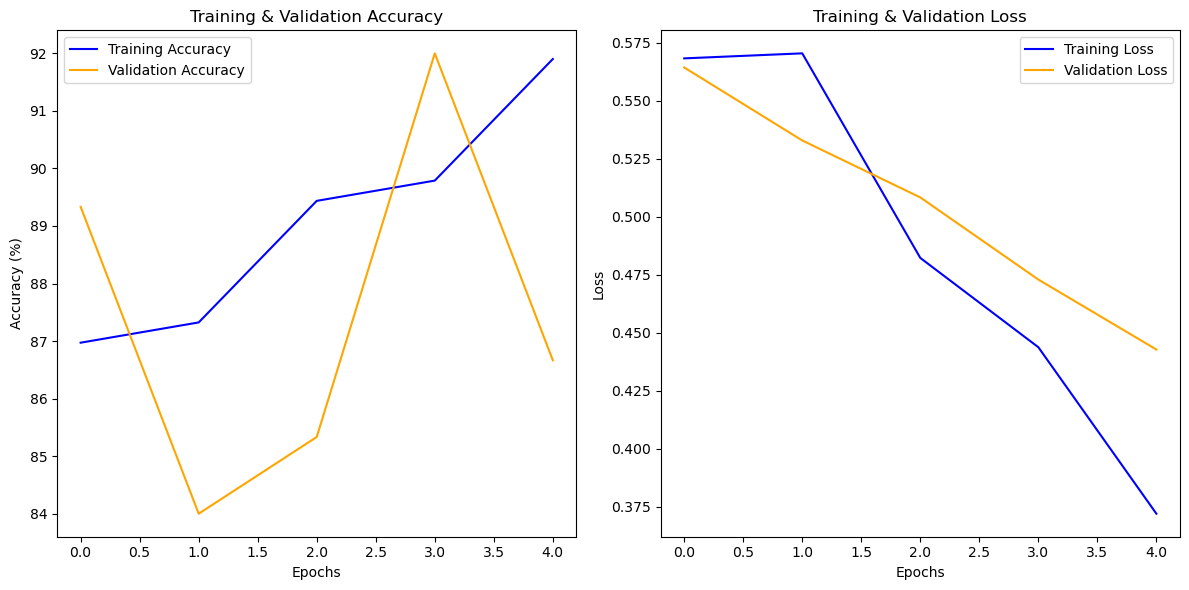

In [36]:
import matplotlib.pyplot as plt

# Plot Training & Validation Accuracy
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(num_epochs), train_accuracies, label='Training Accuracy', color='blue')
plt.plot(range(num_epochs), val_accuracies, label='Validation Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training & Validation Accuracy')
plt.legend()

# Plot Training & Validation Loss
plt.subplot(1, 2, 2)
plt.plot(range(num_epochs), train_losses, label='Training Loss', color='blue')
plt.plot(range(num_epochs), val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()


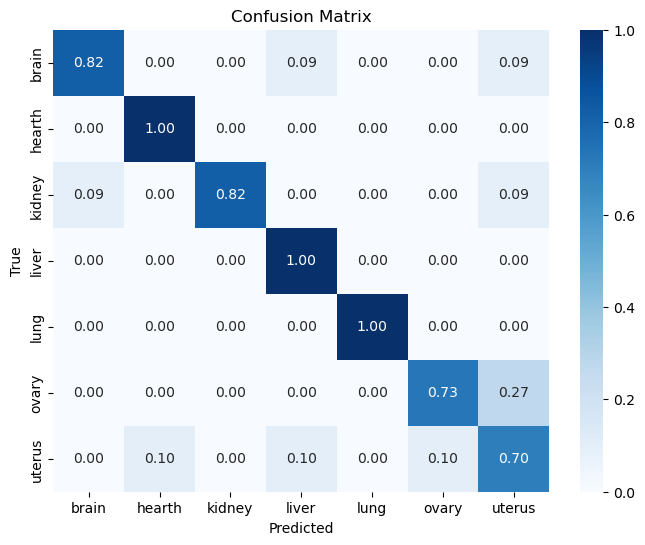

In [38]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

def plot_confusion_matrix(model, val_loader, class_names):
    all_labels = []
    all_preds = []
    model.eval()

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Call this function to plot confusion matrix
plot_confusion_matrix(model, val_loader, class_names)


In [40]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
from matplotlib import cm

In [69]:
def plot_roc_auc(model, val_loader, class_names):
    model.eval()

    # Prepare labels and predictions
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(probs.cpu().numpy())

    # Convert labels to one-hot encoding
    all_labels_one_hot = label_binarize(all_labels, classes=range(len(class_names)))

    # Calculate ROC curve and AUROC for each class
    fpr = {}
    tpr = {}
    roc_auc = {}

    for i in range(len(class_names)):
        fpr[i], tpr[i], _ = roc_curve(all_labels_one_hot[:, i], [pred[i] for pred in all_preds])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve for each class
    plt.figure(figsize=(10, 8))

    colors = cm.get_cmap('tab10', len(class_names))  # 10 distinct colors

    for i in range(len(class_names)):
        plt.plot(fpr[i], tpr[i], color=colors(i), lw=2,
                 label=f'{class_names[i]} (AUROC = {roc_auc[i]:.2f})')

    # Plot the diagonal line (chance level)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')

    # 🔥 Save and show the plot
    plt.savefig("roc_auc_plot.png", dpi=300, bbox_inches='tight')  
    plt.show()



C:\Users\bioha\AppData\Local\Temp\ipykernel_7232\4135148555.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('tab10', len(class_names))  # 10 distinct colors


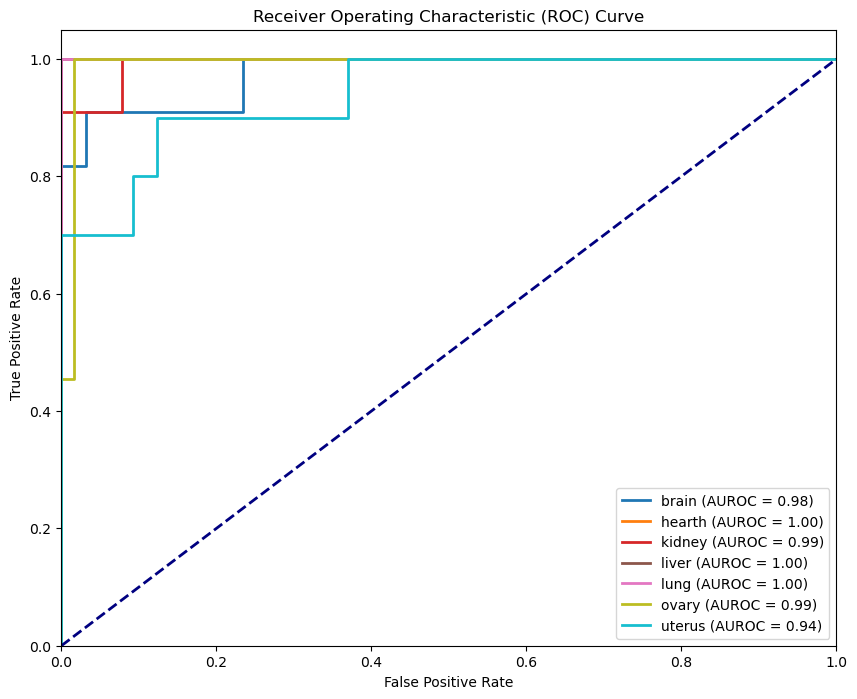

In [71]:
plot_roc_auc(model, val_loader, class_names)


In [53]:
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

def predict_and_plot_confidence(image_path, model, class_names, transform):
    # Load and transform image
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0).to(device)

    # Predict and get probabilities
    model.eval()
    with torch.no_grad():
        outputs = model(input_tensor)
        probs = F.softmax(outputs, dim=1).cpu().numpy().flatten()
        predicted_index = np.argmax(probs)
        predicted_label = class_names[predicted_index]

    # Plot image
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title(f"Predicted: {predicted_label}", fontsize=14)
    plt.axis('off')

    # Plot bar chart
    plt.subplot(1, 2, 2)
    bars = plt.barh(class_names, probs, color='skyblue')
    bars[predicted_index].set_color('orange')
    plt.xlabel('Confidence')
    plt.title('Class Probabilities')

    # Add values on bars
    for i, bar in enumerate(bars):
        plt.text(bar.get_width() + 0.01, bar.get_y() + 0.3, f"{probs[i]:.2f}", fontsize=9)

    plt.tight_layout()
    plt.show()


In [74]:
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from pathlib import Path

def predict_and_plot_confidence(image_path, model, class_names, transform, save_path="prediction_result.png"):
    # Load and transform image
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0).to(device)

    # Predict and get probabilities
    model.eval()
    with torch.no_grad():
        outputs = model(input_tensor)
        probs = F.softmax(outputs, dim=1).cpu().numpy().flatten()
        predicted_index = np.argmax(probs)
        predicted_label = class_names[predicted_index]

    # Plot image
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title(f"Predicted: {predicted_label}", fontsize=14)
    plt.axis('off')

    # Plot bar chart
    plt.subplot(1, 2, 2)
    bars = plt.barh(class_names, probs, color='skyblue')
    bars[predicted_index].set_color('orange')
    plt.xlabel('Confidence')
    plt.title('Class Probabilities')

    # Add values on bars
    for i, bar in enumerate(bars):
        plt.text(bar.get_width() + 0.01, bar.get_y() + 0.3, f"{probs[i]:.2f}", fontsize=9)

    plt.tight_layout()

    # Save the plot
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Saved figure to: {Path(save_path).resolve()}")

    # Show the plot
    plt.show()


Saved figure to: C:\Users\bioha\HandEprediction\predict_02_result.png


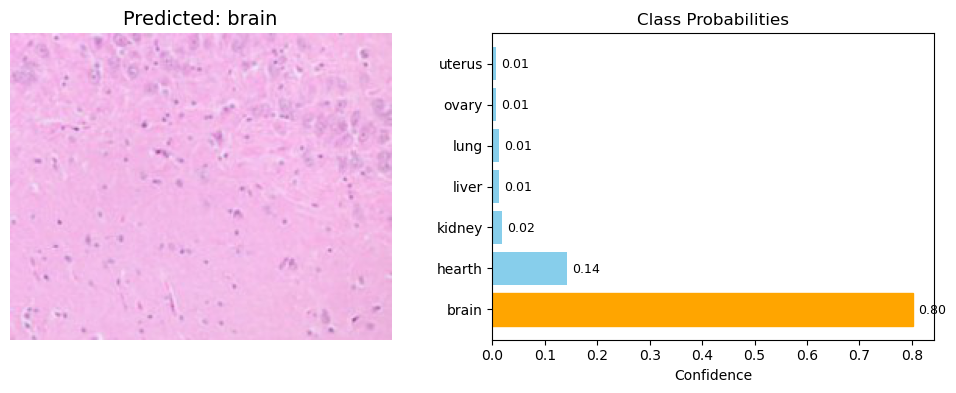

In [76]:
test_img = "predict_02.jpg"
predict_and_plot_confidence(test_img, model, class_names, transform, save_path="predict_02_result.png")